In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
__imp

Libraries have been loaded


In [3]:
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

basepath = os.path.expanduser('~/Desktop/src/ml/lordofmachines/')

## Define Paths

In [4]:
CAMPAIGNS_PATH = os.path.join(basepath, 'data/raw/campaign_data.csv')

# TRAIN_PATH     = os.path.join(basepath, 'data/processed/train.feather')
# TEST_PATH      = os.path.join(basepath, 'data/processed/test.feather')

TRAIN_PATH     = os.path.join(basepath, 'data/processed/val/ctypev5/tr.feather')
TEST_PATH      = os.path.join(basepath, 'data/processed/val/ctypev5/val.feather')

## Load Data

In [5]:
%%time

campaigns = pd.read_csv(f'{CAMPAIGNS_PATH}')
train     = pd.read_feather(f'{TRAIN_PATH}')
test      = pd.read_feather(f'{TEST_PATH}')

CPU times: user 171 ms, sys: 59.8 ms, total: 231 ms
Wall time: 233 ms


In [6]:
traintest = pd.concat((train, test))
ntrain    = len(train)

del train, test
gc.collect();

## Feature Engineering

In [7]:
%%time

def get_most_sent_type(rows):
    return rows.communication_type.value_counts().index.values[0]

def get_avg_diff_send_date(x):
    if len(x) > 1:
        return x.sort_values(by='send_date').loc[:, 'send_date'].diff().dt.days.mean()
    else:
        return -1

traintest.loc[:, 'send_day']     = traintest.send_date.dt.day
traintest.loc[:, 'send_hour']    = traintest.send_date.dt.hour
traintest.loc[:, 'send_weekday'] = traintest.send_date.dt.weekday

traintest.loc[:, 'communication_type'] = pd.factorize(traintest.loc[:, 'communication_type'])[0]

num_emails_sent = traintest.groupby('user_id').size()
traintest.loc[:, 'num_emails_sent'] = traintest.user_id.map(num_emails_sent)

num_emails_opened_before                     = traintest.groupby('user_id')['is_open'].sum()
traintest.loc[:, 'num_emails_opened_before'] = traintest.user_id.map(num_emails_opened_before)

num_diff_email_types                     = traintest.groupby('user_id')['communication_type'].nunique()
traintest.loc[:, 'num_diff_email_types'] = traintest.user_id.map(num_diff_email_types)
    
most_sent_type = traintest.groupby('user_id').apply(get_most_sent_type)
traintest.loc[:, 'most_sent_type'] = traintest.user_id.map(most_sent_type)

diff_hour = traintest.groupby('user_id').apply(lambda x: x.send_date.dt.hour.nunique())
traintest.loc[:, 'diff_hour'] = traintest.user_id.map(diff_hour)

avg_diff_send_date = traintest.groupby('user_id').apply(get_avg_diff_send_date)
traintest.loc[:, 'avg_diff_send_date']  = traintest.user_id.map(avg_diff_send_date)

FEATURES = ['communication_type', 'send_day', 'send_hour', 'send_weekday',
            'total_links', 'no_of_internal_links', 'no_of_images', 'no_of_sections',
            'num_emails_sent', 'num_emails_opened_before', 'num_diff_email_types', 
            'most_sent_type', 'diff_hour', 'avg_diff_send_date'
           ]

X_trn = traintest.iloc[:ntrain][FEATURES]
y_trn = traintest.iloc[:ntrain]['is_click']

X_val = traintest.iloc[ntrain:][FEATURES]
y_val = traintest.iloc[ntrain:]['is_click']

print('Train nulls:\n{}'.format(X_trn.isnull().sum()))
print('\nTest nulls:\n{}'.format(X_val.isnull().sum()))

Train nulls:
communication_type          0
send_day                    0
send_hour                   0
send_weekday                0
total_links                 0
no_of_internal_links        0
no_of_images                0
no_of_sections              0
num_emails_sent             0
num_emails_opened_before    0
num_diff_email_types        0
most_sent_type              0
diff_hour                   0
avg_diff_send_date          0
dtype: int64

Test nulls:
communication_type          0
send_day                    0
send_hour                   0
send_weekday                0
total_links                 0
no_of_internal_links        0
no_of_images                0
no_of_sections              0
num_emails_sent             0
num_emails_opened_before    0
num_diff_email_types        0
most_sent_type              0
diff_hour                   0
avg_diff_send_date          0
dtype: int64
CPU times: user 5min 21s, sys: 1.57 s, total: 5min 22s
Wall time: 5min 23s


## Validation

In [8]:
params = {
    'application': 'binary',
    'metric': 'auc',
    'learning_rate': .1,
    'min_data_in_leaf': 20,
    'num_leaves': 31,
    'feature_fraction': .7,
    'feature_fraction_seed': SEED,
    'nthread': 4
}

ltrain = lgb.Dataset(X_trn, y_trn, feature_name=FEATURES)
leval  = lgb.Dataset(X_val, y_val, feature_name=FEATURES)

valid_sets  = [ltrain, leval]
valid_names = ['train', 'eval']

num_boost_round       = 1000
early_stopping_rounds = 100

m = lgb.train(params, 
              ltrain, 
              num_boost_round, 
              early_stopping_rounds=early_stopping_rounds, 
              valid_names=valid_names,
              valid_sets=valid_sets,
              verbose_eval=20)

Training until validation scores don't improve for 100 rounds.
[20]	train's auc: 0.889774	eval's auc: 0.864962
[40]	train's auc: 0.893586	eval's auc: 0.866239
[60]	train's auc: 0.896719	eval's auc: 0.867098
[80]	train's auc: 0.899113	eval's auc: 0.867369
[100]	train's auc: 0.901031	eval's auc: 0.867445
[120]	train's auc: 0.902875	eval's auc: 0.866773
[140]	train's auc: 0.904282	eval's auc: 0.866801
Early stopping, best iteration is:
[52]	train's auc: 0.895396	eval's auc: 0.867793


`[329]	train's auc: 0.718199	eval's auc: 0.608623`

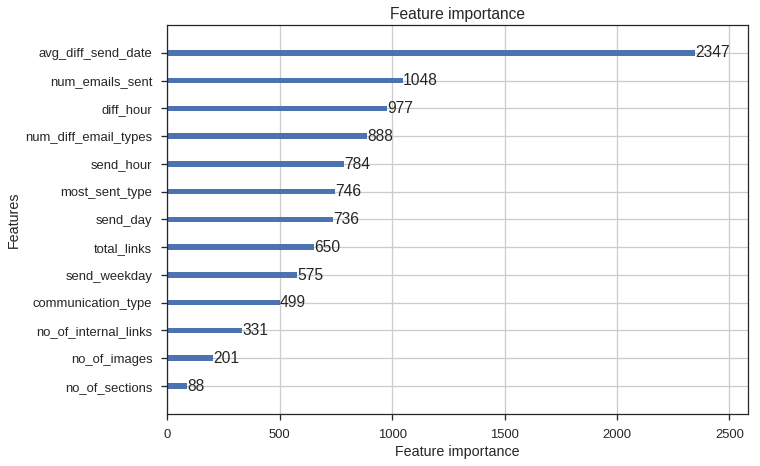

In [10]:
lgb.plot_importance(m);

## Full Training

In [8]:
%%time

params = {
    'application': 'binary',
    'metric': 'auc',
    'learning_rate': (.1 / 1.1),
    'min_data_in_leaf': 20,
    'num_leaves': 31,
    'feature_fraction': .7,
    'feature_fraction_seed': SEED,
    'nthread': 4
}

ltrain          = lgb.Dataset(X_trn, y_trn, feature_name=FEATURES)
num_boost_round = int(329 * 1.1)

m = lgb.train(params, 
              ltrain, 
              num_boost_round)

preds = m.predict(X_val)

CPU times: user 1min 43s, sys: 464 ms, total: 1min 43s
Wall time: 29.1 s


## Submission PB Leaderboard Score: 0.593670898679814

In [9]:
sub = pd.read_csv('../data/raw/sample_submission_4fcZwvQ.csv')
sub.loc[:, 'is_click'] = preds
sub.to_csv('../submissions/submission12.csv', index=False)